# The basis of feature spaces in deep networks

This notebook is connected to a blog post that explores the activation patterns of neurons in a deep network (Inception, trained with ImageNet). It is based on Python/Tensorflow code available [here](https://github.com/tensorflow/models/blob/master/tutorials/image/imagenet/classify_image.py).

As described in more detail in the blog, all of this was inspired by a publication by [Olah et al., Distill (2017)](https://distill.pub/2017/feature-visualization/).

The first part of the code is simply copy-and-pasted from the repository mentioned above. If you are familiar with the Inception network, you might want to jump to the next heading.

In [3]:
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

'''Simple image classification with Inception.

Run image classification with Inception trained on ImageNet 2012 Challenge data
set.

This program creates a graph from a saved GraphDef protocol buffer,
and runs inference on an input JPEG image. It outputs human readable
strings of the top 5 predictions along with their probabilities.

Change the --image_file argument to any jpg image to compute a
classification of that image.

Please see the tutorial and website for a detailed description of how
to use this script to perform image recognition.

https://tensorflow.org/tutorials/image_recognition/
'''

'Simple image classification with Inception.\n\nRun image classification with Inception trained on ImageNet 2012 Challenge data\nset.\n\nThis program creates a graph from a saved GraphDef protocol buffer,\nand runs inference on an input JPEG image. It outputs human readable\nstrings of the top 5 predictions along with their probabilities.\n\nChange the --image_file argument to any jpg image to compute a\nclassification of that image.\n\nPlease see the tutorial and website for a detailed description of how\nto use this script to perform image recognition.\n\nhttps://tensorflow.org/tutorials/image_recognition/\n'

In [9]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os.path
import re
import sys
import tarfile

import numpy as np
from six.moves import urllib
import tensorflow as tf

# added by Peter R. for this notebook
import matplotlib.pyplot as plt
import seaborn as sns
import glob

FLAGS = None

# pylint: disable=line-too-long
DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
# pylint: enable=line-too-long


class NodeLookup(object):
  """Converts integer node ID's to human readable labels."""

  def __init__(self,
               label_lookup_path=None,
               uid_lookup_path=None):
    if not label_lookup_path:
      label_lookup_path = os.path.join(
          FLAGS.model_dir, 'imagenet_2012_challenge_label_map_proto.pbtxt')
    if not uid_lookup_path:
      uid_lookup_path = os.path.join(
          FLAGS.model_dir, 'imagenet_synset_to_human_label_map.txt')
    self.node_lookup = self.load(label_lookup_path, uid_lookup_path)

  def load(self, label_lookup_path, uid_lookup_path):
    """Loads a human readable English name for each softmax node.

    Args:
      label_lookup_path: string UID to integer node ID.
      uid_lookup_path: string UID to human-readable string.

    Returns:
      dict from integer node ID to human-readable string.
    """
    if not tf.gfile.Exists(uid_lookup_path):
      tf.logging.fatal('File does not exist %s', uid_lookup_path)
    if not tf.gfile.Exists(label_lookup_path):
      tf.logging.fatal('File does not exist %s', label_lookup_path)

    # Loads mapping from string UID to human-readable string
    proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
    uid_to_human = {}
    p = re.compile(r'[n\d]*[ \S,]*')
    for line in proto_as_ascii_lines:
      parsed_items = p.findall(line)
      uid = parsed_items[0]
      human_string = parsed_items[2]
      uid_to_human[uid] = human_string

    # Loads mapping from string UID to integer node ID.
    node_id_to_uid = {}
    proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
    for line in proto_as_ascii:
      if line.startswith('  target_class:'):
        target_class = int(line.split(': ')[1])
      if line.startswith('  target_class_string:'):
        target_class_string = line.split(': ')[1]
        node_id_to_uid[target_class] = target_class_string[1:-2]

    # Loads the final mapping of integer node ID to human-readable string
    node_id_to_name = {}
    for key, val in node_id_to_uid.items():
      if val not in uid_to_human:
        tf.logging.fatal('Failed to locate: %s', val)
      name = uid_to_human[val]
      node_id_to_name[key] = name

    return node_id_to_name

  def id_to_string(self, node_id):
    if node_id not in self.node_lookup:
      return ''
    return self.node_lookup[node_id]


def create_graph():
  """Creates a graph from saved GraphDef file and returns a saver."""
  # Creates graph from saved graph_def.pb.
  with tf.gfile.FastGFile(os.path.join(
      FLAGS.model_dir, 'classify_image_graph_def.pb'), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')


def maybe_download_and_extract():
  """Download and extract model tar file."""
  dest_directory = FLAGS.model_dir
  if not os.path.exists(dest_directory):
    os.makedirs(dest_directory)
  filename = DATA_URL.split('/')[-1]
  filepath = os.path.join(dest_directory, filename)
  if not os.path.exists(filepath):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\r>> Downloading %s %.1f%%' % (
          filename, float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()
    filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
  tarfile.open(filepath, 'r:gz').extractall(dest_directory)


# the following part is slightly modified (Peter R.)
parser = argparse.ArgumentParser()
# classify_image_graph_def.pb:
#   Binary representation of the GraphDef protocol buffer.
# imagenet_synset_to_human_label_map.txt:
#   Map from synset ID to a human readable string.
# imagenet_2012_challenge_label_map_proto.pbtxt:
#   Text representation of a protocol buffer mapping a label to synset ID.
parser.add_argument(
  '--model_dir',
  type=str,
  default='/tmp/imagenet',
  help="""\
  Path to classify_image_graph_def.pb,
  imagenet_synset_to_human_label_map.txt, and
  imagenet_2012_challenge_label_map_proto.pbtxt.\
  """
)
parser.add_argument(
  '--image_file',
  type=str,
  default='',
  help='Absolute path to image file.'
)
parser.add_argument(
  '--num_top_predictions',
  type=int,
  default=5,
  help='Display this many predictions.'
)
FLAGS, unparsed = parser.parse_known_args()


# Prepare model and data

In [19]:
# Downloads the inception model
maybe_download_and_extract()

# Creates graph from saved GraphDef.
create_graph()

# Defines the layers to be analyzed
Layers = [ 'conv','conv_1','conv_2','conv_3','conv_4','mixed/join','mixed_2/join','mixed_3/join', 'mixed_4/join','mixed_5/join','mixed_6/join','mixed_7/join','mixed_8/join','mixed_9/join','mixed_10/join','softmax']

# Gets all layer names in the first place:
#for op in sess.graph.get_operations():
#    print(str(op.name))

# Finds all pictures available
FileList_anima = glob.glob('AnimalPics/*.jpg')

7

# Extracts distributions of activations from each layer

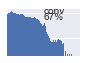

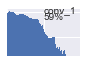

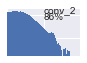

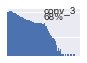

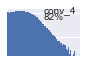

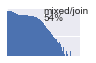

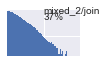

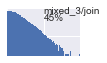

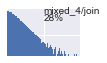

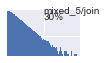

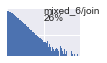

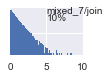

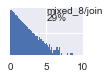

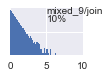

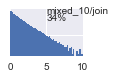

In [20]:
# Starts an interactive Tensorflow session
sess = tf.InteractiveSession()

# This is probably not the best way to initialize this structure, but it works ...
activations_all = np.array([None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None])

# Go through each picture (kk) and then each layer of the network (i) and extract the activations
for kk in range(len(FileList_anima)):
    image = FileList_anima[kk]
    image_data = tf.gfile.FastGFile(image, 'rb').read()
    for i,layer in enumerate(Layers[:]):
        layerX = sess.graph.get_tensor_by_name(layer+':0')
        activations = sess.run(layerX,{'DecodeJpeg/contents:0': image_data})
        activations = np.squeeze(activations)
        flat_activations = activations.flatten()
        activations_all[i] = np.append(activations_all[i],flat_activations)

# Closes Tensorflow session        
sess.close()

# Allows plotting in the Jupyter Notebook
%matplotlib inline

# Plots histograms of activation patterns for each layer
plt.figure(116)
for kk in range(len(Layers)-1):
    # Extracts activations for the respective layer
    AA = activations_all[kk][1:]
    # Quantifies percentage of silent neurons
    percentage = len(AA[AA>0])/len(AA)
    # Plots histograms
    ax = plt.subplot(4, 4, kk+1)
    plt.hist(AA[AA>0],100) # only non-zero activations
    
    # Beautifications
    plt.text(5, ax.get_ylim()[1]*0.4, Layers[kk])
    plt.text(5, ax.get_ylim()[1]*0.08,'%02d%%' % np.round(100.0*percentage))
    plt.yscale('log', nonposy='clip') # logscale
    plt.tick_params(
    axis='y',        
    left='off',      
    right='off',        
    labelleft='off')
    plt.xlim([0,10])
    if kk < 11:
        plt.tick_params(
        axis='x',          # changes apply to the x-axis
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off') # labels along the bottom edge are off
    plt.show()

# Plots activation levels together with de-correlation of activation patterns

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


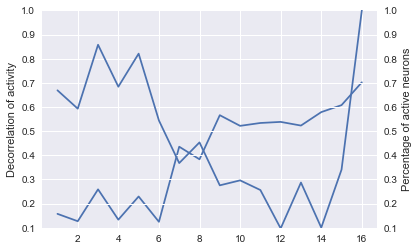

In [21]:
# Starts an interactive Tensorflow session
sess = tf.InteractiveSession()

# Computes correlations between evoked activation patterns of stimulus pairs
nb_pairs = 20
Correlation_structure = np.zeros((nb_pairs,len(Layers)))
for kk in range(nb_pairs):
    print(kk)
    # Chooses two randomly selected input images
    ixs = np.random.choice(len(FileList_anima),2)
    # Loads the two images
    image1 = FileList_anima[ixs[0]]
    image_data1 = tf.gfile.FastGFile(image1, 'rb').read()
    image2 = FileList_anima[ixs[1]]
    image_data2 = tf.gfile.FastGFile(image2, 'rb').read()
    # Computes the correlations between the two activation patterns for each layer
    for i,layer in enumerate(Layers[:]):
        layerX = sess.graph.get_tensor_by_name(layer+':0')
        activations1 = sess.run(layerX,{'DecodeJpeg/contents:0': image_data1})
        activations1 = np.squeeze(activations1)
        flat_activations1 = activations1.flatten()
        activations2 = sess.run(layerX,{'DecodeJpeg/contents:0': image_data2})
        activations2 = np.squeeze(activations2)
        flat_activations2 = activations2.flatten()

        Correlation_structure[kk,i] = np.corrcoef(flat_activations1,flat_activations2)[0,1]

# Percentage of activated neurons for each layer, as computed before
percentageX = np.zeros((len(Layers),1))
for kk in range(len(Layers)):
    AA = activations_all[kk][1:]
    percentageX[kk] = len(AA[AA>0])/len(AA)

# Plots both correlations between activation patterns and percentage of activated neurons as a function of layer
# Layers close to the input are to the left, layers close to the output are located to the right side
plt.figure(21)
fig, ax1 = plt.subplots()
sns.set(color_codes=True)
ax1.plot(np.arange(1,17),np.mean(1-Correlation_structure[0:,:],axis=0))
ax1.set_ylabel('Decorrelation of activity')
ax1.set_ylim([0.1, 1])
ax2 = ax1.twinx()
ax2.plot(np.arange(1,17),percentageX)
ax2.set_ylabel('Percentage of active neurons')
ax2.set_xlabel('Layer index')
ax2.set_ylim([0.1, 1])

# Closes interactive Tensorflow session
sess.close()